# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [13]:
skyserver_ds = pd.read_csv('/home/jovyan/MLGeo-Autumn22/homework/Skyserver_SQL2_27_2018.csv')

**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [14]:
skyserver_ds.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [15]:
skyserver_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [16]:
skyserver_ds = skyserver_ds.drop(['objid','specobjid','run','rerun','camcol','field','plate','mjd','fiberid'], axis = 1)

Find out how many examples there are, how many attributes or feature, and the type of class.

 - Examples: there are 10,000 observations reported in the SkyServer database
 - Attributes or Features: there are 11 features including ra, dec, u, g, r, i, z, redshift, plate, mjd, and fiberid
 - Types of Classes: there are three possible classes including star, galaxy, and quasars

**Task: How many objects are in each class? (1 point)**

In [17]:
# Count the elements in each class
skyserver_ds['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [18]:
skyserver_ds_save = skyserver_ds # make a copy of the original data before cleaning it. That works well when the data is small.

In [19]:
# encode class labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(skyserver_ds['class'])
skyserver_ds['class'] = y_encoded
#  GALAXY = 0
# STAR = 1
# QSO = 2

### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

Below are the correlations that show values above 0.6:

 - u: g, r, i
 - g: r, i, z
 - r: i, z
 - i: z

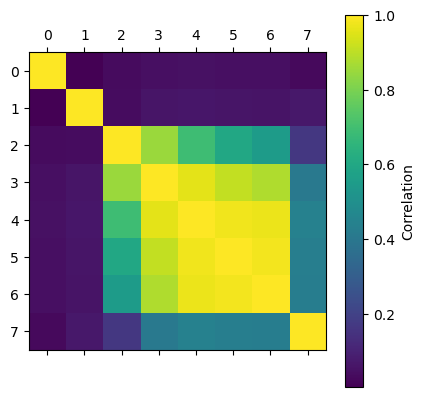

In [28]:
import seaborn as sns
skyserver_corr = skyserver_ds.drop('class', axis = 1).corr()
plt.matshow(skyserver_corr)
plt.colorbar(label = 'Correlation')

**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

<AxesSubplot: >

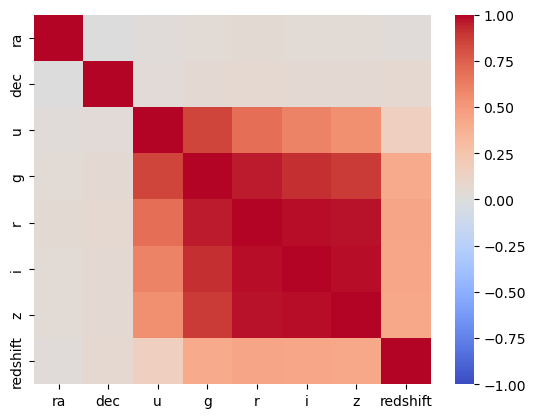

In [29]:
sns.heatmap(skyserver_corr, center = 0, vmin = -1, vmax = 1, cmap = 'coolwarm')

**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

<AxesSubplot: >

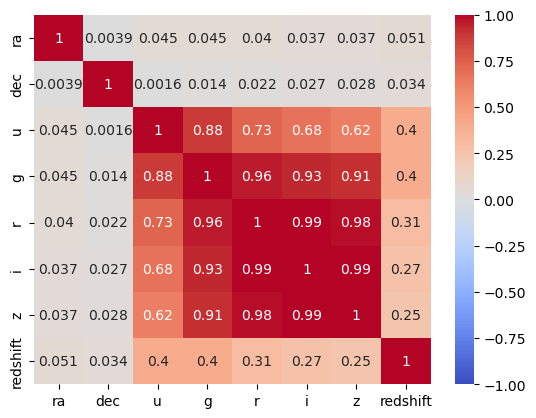

In [36]:
skyserver_galaxy = skyserver_ds.loc[skyserver_ds['class'] == 0]
sns.heatmap(skyserver_galaxy.drop('class', axis =1).corr(), annot = True, 
            center = 0, vmin = -1, vmax = 1, cmap = 'coolwarm')


<AxesSubplot: >

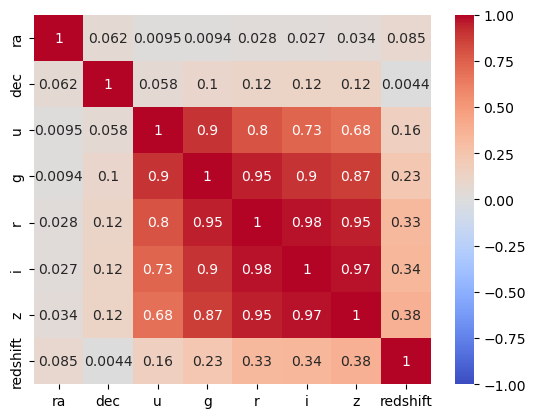

In [35]:
skyserver_stars = skyserver_ds.loc[skyserver_ds['class'] == 1]
sns.heatmap(skyserver_stars.drop('class', axis =1).corr(), annot = True,
            center = 0, vmin = -1, vmax = 1, cmap = 'coolwarm')

<AxesSubplot: >

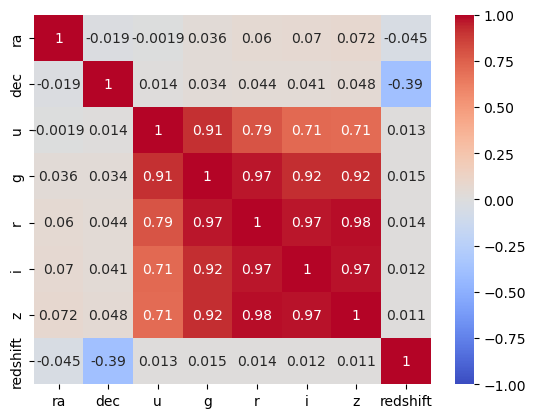

In [34]:
skyserver_quasars = skyserver_ds.loc[skyserver_ds['class'] == 2]
sns.heatmap(skyserver_quasars.drop('class', axis =1).corr(), annot = True, 
            center = 0, vmin = -1, vmax = 1, cmap = 'coolwarm')

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

 - For all 3 classes, it looks like u, g, r, i, and z are highly correlated with each other
 - For most variables, there is a positive correlation. Only for the Quasar class between dev and redshift and ra and redshift are there negative correlations

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

Text(0, 0.5, 'Counts')

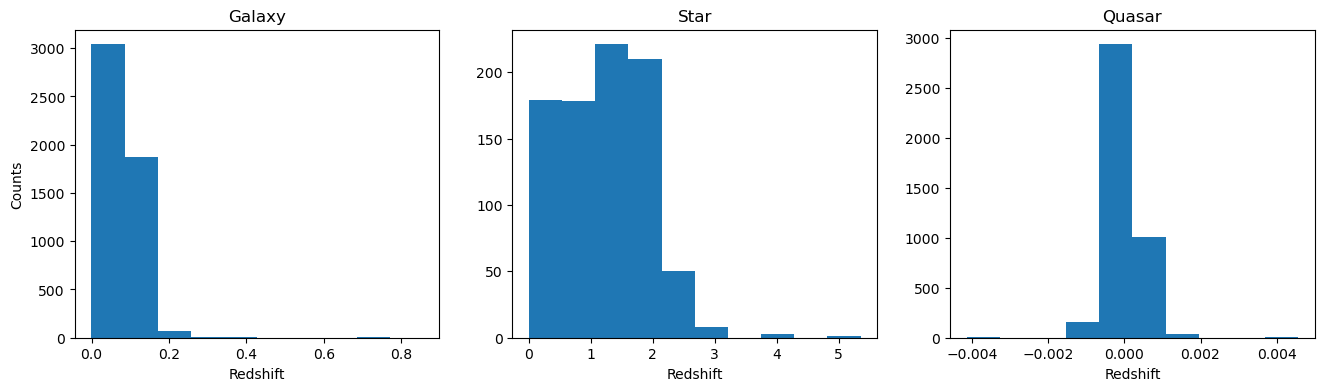

In [42]:
# answer
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
axes[0].hist(skyserver_ds['redshift'].loc[skyserver_ds['class'] == 0])
axes[1].hist(skyserver_ds['redshift'].loc[skyserver_ds['class'] == 1])
axes[2].hist(skyserver_ds['redshift'].loc[skyserver_ds['class'] == 2])

axes[0].set_title('Galaxy')
axes[1].set_title('Star')
axes[2].set_title('Quasar')
axes[0].set_xlabel('Redshift')
axes[1].set_xlabel('Redshift')
axes[2].set_xlabel('Redshift')

axes[0].set_ylabel('Counts')

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasards are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

Text(0.5, 1.0, 'Equatorial coordinates')

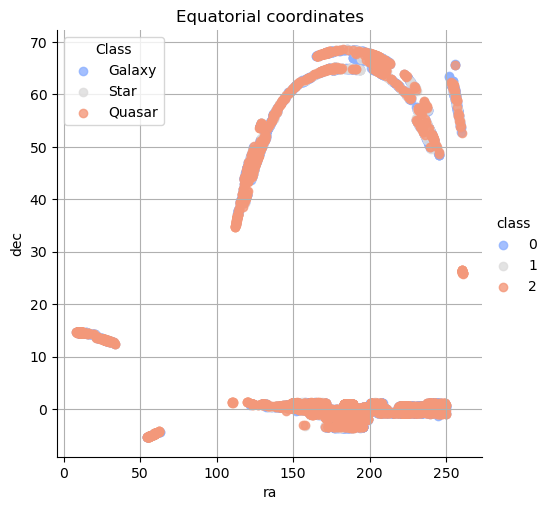

In [46]:
sns.lmplot(x='ra', y='dec', data=skyserver_ds, hue='class', fit_reg=False, palette='coolwarm')#, size=6, aspect=2,legend=False)
plt.legend(title='Class', loc='upper left', labels=['Galaxy', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

 - In general, the two coordinates vary quite closely with one another. However, dec does gravitate towards negative values while ra always stays positive.

#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task Plot histograms and discuss why you expect these features to be correlated (1 points)**

Text(162.59722222222223, 0.5, 'Counts')

<Figure size 640x480 with 0 Axes>

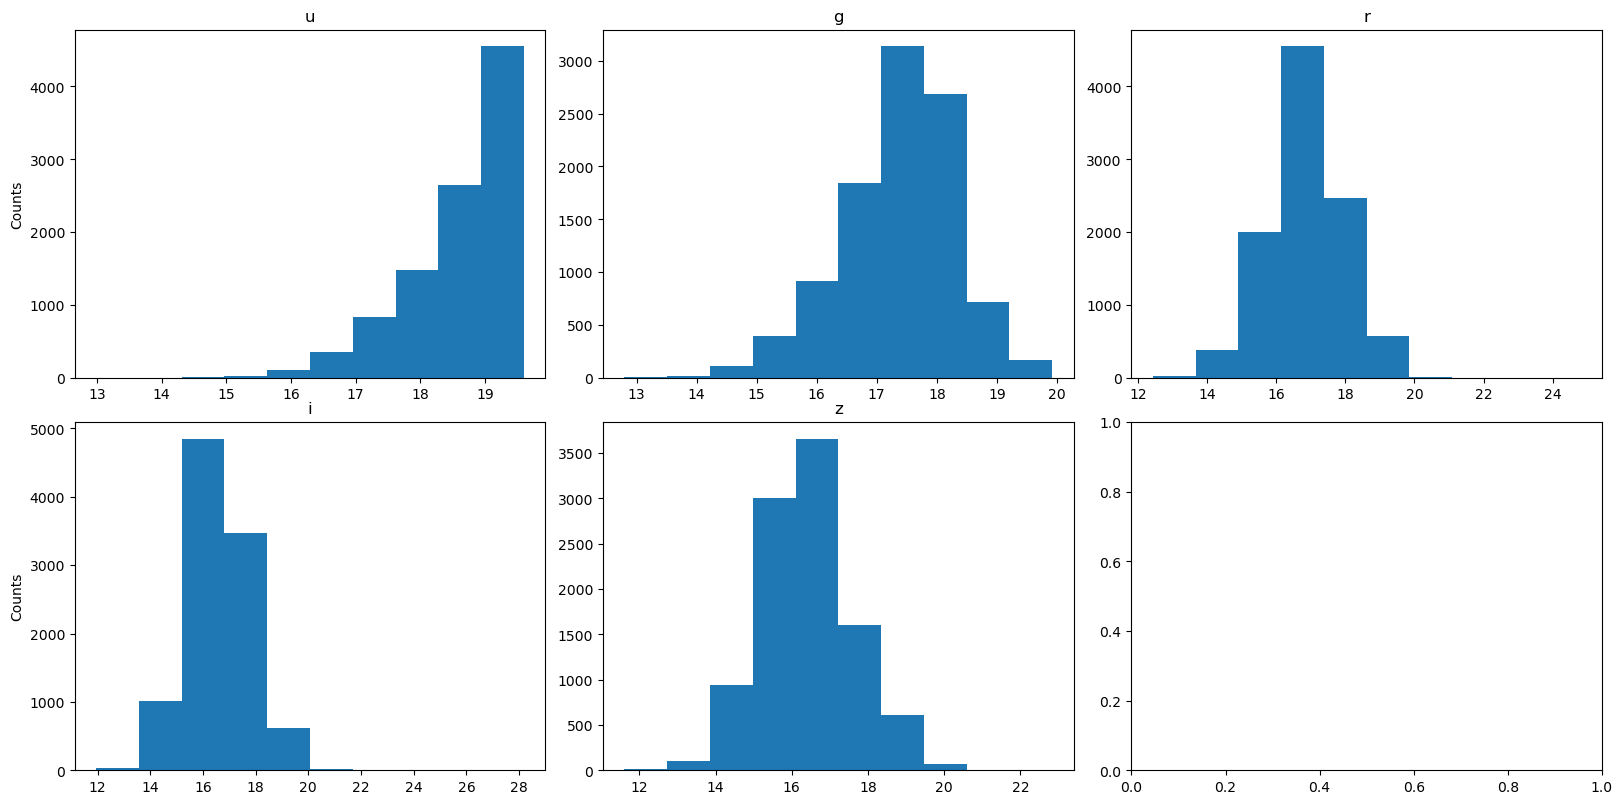

In [57]:
# Plot of histograms
import warnings
warnings.filterwarnings('ignore')
plt.figure()

fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(16, 8))
fig.tight_layout()
axes[0,0].hist(skyserver_ds['u'])
axes[0,1].hist(skyserver_ds['g'])
axes[0,2].hist(skyserver_ds['r'])
axes[1,0].hist(skyserver_ds['i'])
axes[1,1].hist(skyserver_ds['z'])

axes[0,0].set_title('u')
axes[0,1].set_title('g')
axes[0,2].set_title('r')
axes[1,0].set_title('i')
axes[1,1].set_title('z')

axes[0,0].set_ylabel('Counts')
axes[1,0].set_ylabel('Counts')

 - It looks like variables g, r, i and z have relatively normal distributions while u does not

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

In [59]:
from sklearn.decomposition import PCA
skyserver_ds

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590
...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019


In [60]:
pca_results = PCA().fit(skyserver_ds[['u','g','r','i','z']])
pca_results.explained_variance_ratio_

array([0.90265505, 0.08753264, 0.00458021, 0.0040977 , 0.0011344 ])

 - From the PCA performed above, it looks like only 1 PC is needed 

We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [67]:
skyserver_ds

,ra,dec,u,g,r,i,z,class,redshift
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009
1,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590
...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019


In [68]:
pca_results_2 = PCA(n_components = 1).fit(skyserver_ds[['u','g','r','i','z']])
pca_transformed = pca_results_2.transform(skyserver_ds[['u','g','r','i','z']])
print("original shape:   ", skyserver_ds[['u','g','r','i','z']].shape)
print("transformed shape:", pca_transformed.shape)

skyserver_updated = skyserver_ds[['ra','dec','redshift']]
skyserver_updated['PCA'] = pca_transformed
skyserver_updated

original shape:    (10000, 5)
transformed shape: (10000, 1)


,ra,dec,redshift,PCA
0,183.531326,0.089693,-0.000009,-1.507202
1,183.598370,0.135285,-0.000055,-0.195758
2,183.680207,0.126185,0.123111,1.297604
3,183.870529,0.049911,-0.000111,-1.446117
4,183.883288,0.102557,0.000590,-0.849271
...,...,...,...,...
9995,131.316413,51.539547,0.027583,0.222959
9996,131.306083,51.671341,0.117772,0.259171
9997,131.552562,51.666986,-0.000402,1.480725
9998,131.477151,51.753068,0.014019,1.392088


## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [80]:
skyserver_noclass = skyserver_ds.drop('class', axis = 1)

from sklearn import preprocessing

x = skyserver_noclass.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)
df_scaled = df_scaled.rename(columns = {0:'ra',1:'dec',2:'u',3:'g',4:'r',5:'i',6:'z',7:'redshift'})
df_scaled

,ra,dec,u,g,r,i,z,redshift
0,0.693832,0.074025,0.980965,0.595954,0.284177,0.219081,0.322108,0.000770
1,0.694098,0.074642,0.858250,0.620126,0.343138,0.279811,0.426021,0.000762
2,0.694422,0.074519,0.967188,0.757385,0.407640,0.316657,0.462532,0.023749
3,0.695175,0.073487,0.722499,0.534197,0.301490,0.248584,0.382616,0.000751
4,0.695225,0.074199,0.689960,0.486538,0.323925,0.283858,0.445782,0.000882
...,...,...,...,...,...,...,...,...
9995,0.487163,0.770000,0.881691,0.656090,0.362435,0.291752,0.436197,0.005920
9996,0.487122,0.771783,0.799219,0.651590,0.375518,0.293819,0.453419,0.022753
9997,0.488097,0.771724,0.872678,0.699255,0.411232,0.337954,0.517709,0.000697
9998,0.487799,0.772888,0.891539,0.717914,0.412267,0.333630,0.492706,0.003388


### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [89]:
features = np.array(df_scaled)
labels = np.array(skyserver_ds['class'])

In [91]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [94]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
label_names = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [97]:
#answer
from sklearn.neighbors import KNeighborsClassifier
print("Classifying using K-nearest Neighbors")

t1 = time.perf_counter()

knn_clf = KNeighborsClassifier() # model design
knn_clf.fit(train_features, train_labels) # learn
knn_prediction = knn_clf.predict(test_features) # predict on test

t2 = time.perf_counter()
tcomp = t2-t1
print('Total run time: '+ str(tcomp))

print("K-nearest Neighbors Accuracy:", metrics.accuracy_score(y_true = test_labels, y_pred = knn_prediction))
print(f"Classification report for classifier {knn_clf}:\n"
      f"{metrics.classification_report(test_labels, knn_prediction)}\n")



Classifying using K-nearest Neighbors
Total run time: 0.11990368366241455
K-nearest Neighbors Accuracy: 0.872
Classification report for classifier KNeighborsClassifier():
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1246
           1       0.99      0.92      0.95       242
           2       0.82      0.89      0.85      1012

    accuracy                           0.87      2500
   macro avg       0.90      0.89      0.89      2500
weighted avg       0.87      0.87      0.87      2500




In [103]:
classification_report = pd.DataFrame(index = ['KNN','NB','RFC','SVMC','MLP'],
                                     columns = ['precision','recall','f-score','accuracy'])

In [106]:
classification_report['precision'].loc['KNN'] = metrics.precision_score(test_labels, knn_prediction, average = 'weighted')
classification_report['recall'].loc['KNN'] = metrics.recall_score(test_labels, knn_prediction, average = 'weighted')
classification_report['f-score'].loc['KNN'] = metrics.f1_score(test_labels, knn_prediction, average = 'weighted')
classification_report['accuracy'].loc['KNN'] = metrics.accuracy_score(test_labels, knn_prediction)

### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [123]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
print("Classifying using Gaussian Naive Bayes")

# model design

# re-scale the data
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(skyserver_noclass)
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(features, labels, test_size=0.33)

t1 = time.perf_counter()

gnb = GaussianNB() # model design
gnb.fit(train_features, train_labels) # learn
gnb_prediction = gnb.predict(test_features) # predict on test

t2 = time.perf_counter()
tcomp = t2-t1
print('Total run time: '+ str(tcomp))

print("Gaussian Naive Bayes Accuracy:", metrics.accuracy_score(y_true = test_labels, y_pred = gnb_prediction))
print(f"Classification report for classifier {gnb}:\n"
      f"{metrics.classification_report(test_labels, gnb_prediction)}\n")

Classifying using Gaussian Naive Bayes
Total run time: 0.00427551195025444
Gaussian Naive Bayes Accuracy: 0.9804
Classification report for classifier GaussianNB():
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1246
           1       0.89      0.95      0.92       242
           2       0.99      0.99      0.99      1012

    accuracy                           0.98      2500
   macro avg       0.96      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500




In [124]:
classification_report['precision'].loc['NB'] = metrics.precision_score(test_labels, gnb_prediction, average = 'weighted')
classification_report['recall'].loc['NB'] = metrics.recall_score(test_labels, gnb_prediction, average = 'weighted')
classification_report['f-score'].loc['NB'] = metrics.f1_score(test_labels, gnb_prediction, average = 'weighted')
classification_report['accuracy'].loc['NB'] = metrics.accuracy_score(test_labels, gnb_prediction)

### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [110]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")

t1 = time.perf_counter()

rf_clf = RandomForestClassifier(random_state=42, verbose=True) # model design
rf_clf.fit(train_features, train_labels)# learn
rf_prediction = rf_clf.predict(test_features) # predict on test

t2 = time.perf_counter()
tcomp = t2-t1
print('Total run time: '+ str(tcomp))


print("Random Forest Accuracy:", metrics.accuracy_score(y_true=test_labels ,y_pred=rf_prediction))
print(f"Classification report for classifier {rf_clf}:\n"
      f"{metrics.classification_report(test_labels, rf_prediction)}\n")

Classifying using Random Forest Classifiers


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Total run time: 1.2966220751404762
Random Forest Accuracy: 0.9916
Classification report for classifier RandomForestClassifier(random_state=42, verbose=True):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1246
           1       0.99      0.95      0.97       242
           2       0.99      1.00      1.00      1012

    accuracy                           0.99      2500
   macro avg       0.99      0.98      0.99      2500
weighted avg       0.99      0.99      0.99      2500




[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [114]:
classification_report['precision'].loc['RFC'] = metrics.precision_score(test_labels, rf_prediction, average = 'weighted')
classification_report['recall'].loc['RFC'] = metrics.recall_score(test_labels, rf_prediction, average = 'weighted')
classification_report['f-score'].loc['RFC'] = metrics.f1_score(test_labels, rf_prediction, average = 'weighted')
classification_report['accuracy'].loc['RFC'] = metrics.accuracy_score(test_labels, rf_prediction)

### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [127]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")

t1 = time.perf_counter()

svc = SVC(gamma=0.001) # model design
svc.fit(train_features, train_labels) # learn
svc_prediction = svc.predict(test_features) # predict on test

t2 = time.perf_counter()
tcomp = t2-t1
print('Total run time: '+ str(tcomp))


print(f"Classification report for classifier {svc}:\n"
      f"{metrics.classification_report(test_labels, svc_prediction)}\n")
print("SVC Accuracy:", metrics.accuracy_score(y_true=test_labels ,y_pred=svc_prediction))

Classifying using Support Vector Machine Classfiers
Total run time: 6.408288887701929
Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1246
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00      1012

    accuracy                           0.50      2500
   macro avg       0.17      0.33      0.22      2500
weighted avg       0.25      0.50      0.33      2500


SVC Accuracy: 0.4984


In [128]:
classification_report['precision'].loc['SVMC'] = metrics.precision_score(test_labels, svc_prediction, average = 'weighted')
classification_report['recall'].loc['SVMC'] = metrics.recall_score(test_labels, svc_prediction, average = 'weighted')
classification_report['f-score'].loc['SVMC'] = metrics.f1_score(test_labels, svc_prediction, average = 'weighted')
classification_report['accuracy'].loc['SVMC'] = metrics.accuracy_score(test_labels, svc_prediction)

### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [118]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")

t1 = time.perf_counter()

mlp = MLPClassifier(random_state=42, max_iter=150) # model design
mlp.fit(train_features, train_labels) # learn
mlp_prediction = mlp.predict(test_features) # predict on test

t2 = time.perf_counter()
tcomp = t2-t1
print('Total run time: '+ str(tcomp))

print(f"Classification report for classifier {mlp}:\n"
      f"{metrics.classification_report(test_labels, mlp_prediction)}\n")

Classifying using Multi Layer Perceptron Classifier
Total run time: 4.409711444750428
Classification report for classifier MLPClassifier(max_iter=150, random_state=42):
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1246
           1       0.99      0.94      0.96       242
           2       0.95      0.99      0.97      1012

    accuracy                           0.97      2500
   macro avg       0.97      0.96      0.97      2500
weighted avg       0.97      0.97      0.97      2500




In [121]:
classification_report['precision'].loc['MLP'] = metrics.precision_score(test_labels, mlp_prediction, average = 'weighted')
classification_report['recall'].loc['MLP'] = metrics.recall_score(test_labels, mlp_prediction, average = 'weighted')
classification_report['f-score'].loc['MLP'] = metrics.f1_score(test_labels, mlp_prediction, average = 'weighted')
classification_report['accuracy'].loc['MLP'] = metrics.accuracy_score(test_labels, mlp_prediction)

In [125]:
classification_report

,precision,recall,f-score,accuracy
KNN,0.874831,0.872,0.872543,0.872
NB,0.981131,0.9804,0.980632,0.9804
RFC,0.991582,0.9916,0.991559,0.9916
SVMC,0.248403,0.4984,0.331557,0.4984
MLP,0.968645,0.968,0.96798,0.968


### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


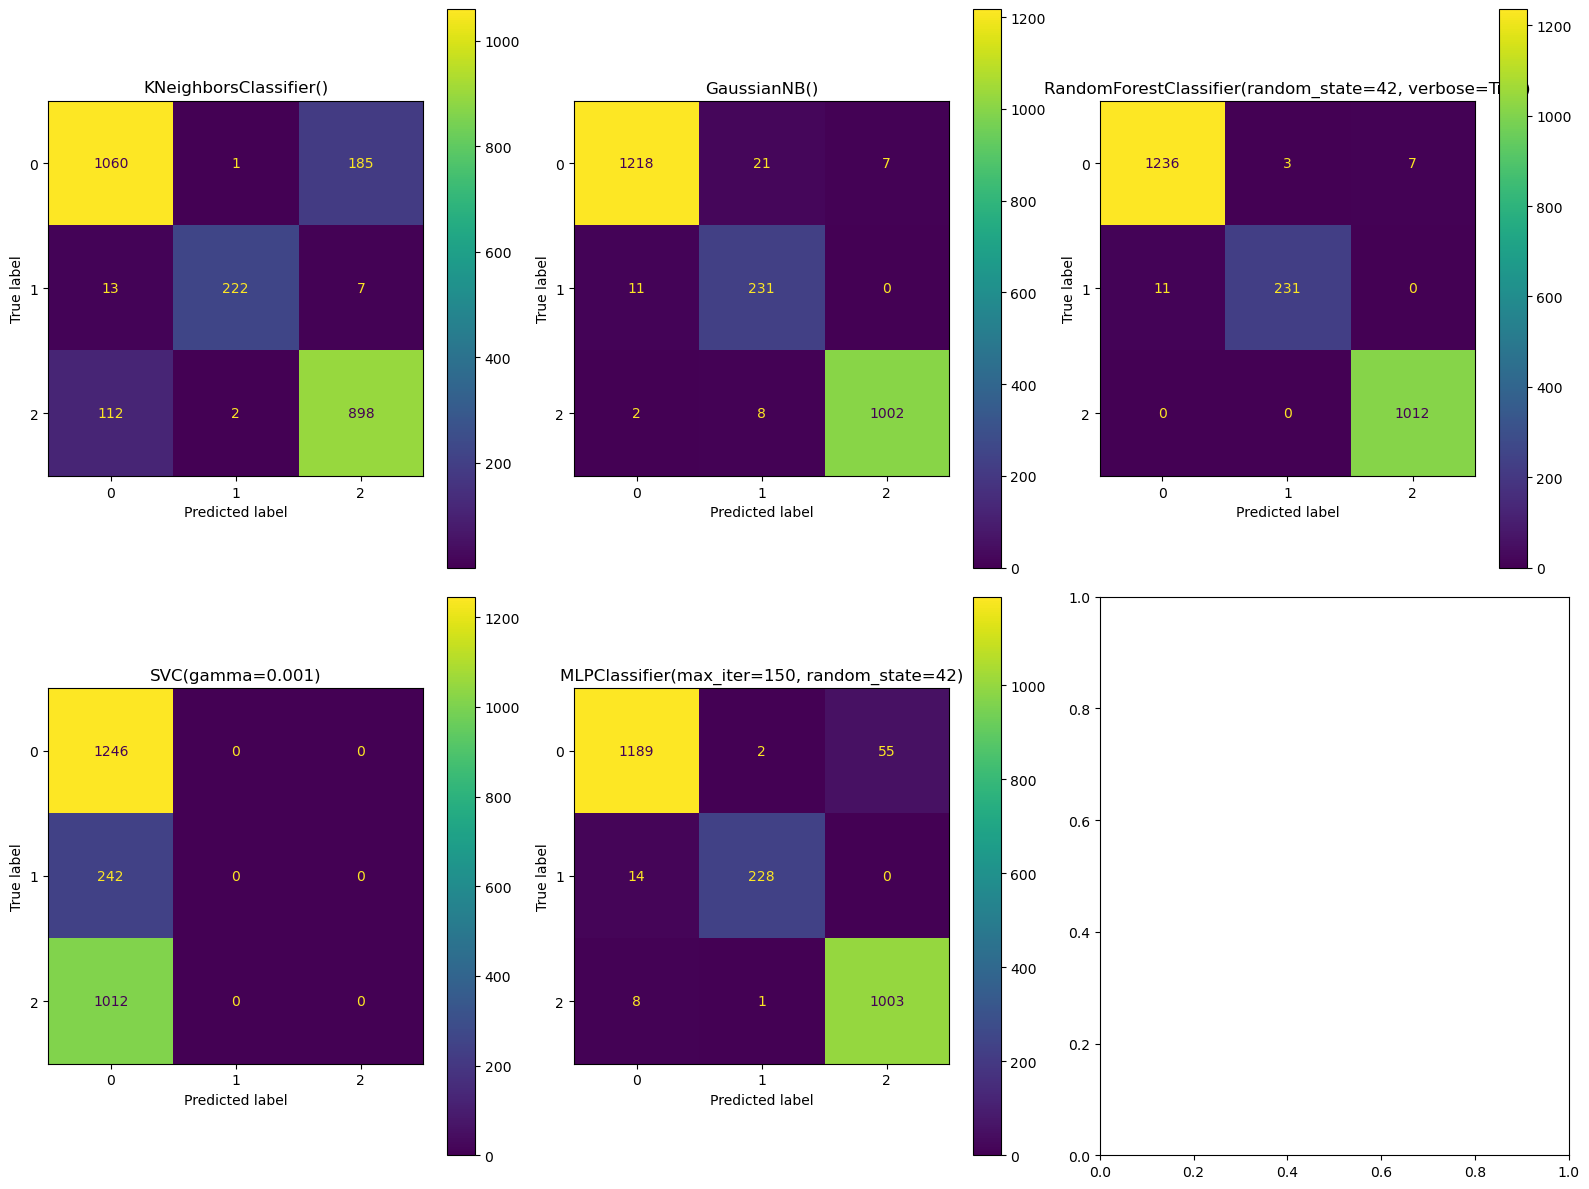

In [136]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16,12), tight_layout = True)
methods = [knn_clf,gnb,rf_clf,svc,mlp]
axes = axes.flatten()
for i in range(0,5):
    method = methods[i]
    metrics.plot_confusion_matrix(method, test_features, test_labels, ax = axes[i])
    axes[i].set_title(method)

**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

In [137]:
classification_report

,precision,recall,f-score,accuracy
KNN,0.874831,0.872,0.872543,0.872
NB,0.981131,0.9804,0.980632,0.9804
RFC,0.991582,0.9916,0.991559,0.9916
SVMC,0.248403,0.4984,0.331557,0.4984
MLP,0.968645,0.968,0.96798,0.968


 - From the results above, RFC and GNB and MLP have the highest accuracies! They are also very precise compared to the other classifier methods
 - SVMC performs the worst and has the highest confusion rates

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [138]:
classification_reportlearn.model_selection import cross_val_score

scores_knn = cross_val_score(knn_clf,  train_features, train_labels, scoring='accuracy', cv=10)
print("K-nearest neighbors Mean:", scores_knn.mean(),"Standard Deviation:", scores_knn.std())

scores_nb = cross_val_score(gnb,  train_features, train_labels, scoring='accuracy', cv=10)
print("Gaussian Naive Bayes Mean:", scores_nb.mean(),"Standard Deviation:", scores_nb.std())

scores_rfc = cross_val_score(rf_clf,  train_features, train_labels, scoring='accuracy', cv=10)
print("Random Forest Mean:", scores_rfc.mean(),"Standard Deviation:", scores_rfc.std())

scores_svc = cross_val_score(svc,  train_features, train_labels, scoring='accuracy', cv=10)
print("Support Vector Machine Classifier Mean:", scores_svc.mean(),"Standard Deviation:", scores_svc.std())

scores_mlp = cross_val_score(mlp,  train_features, train_labels, scoring='accuracy', cv=10)
print("Multi-layer Perceptron Mean:", scores_mlp.mean(),"Standard Deviation:", scores_mlp.std())


K-nearest neighbors Mean: 0.8712 Standard Deviation: 0.012805554350445834
Gaussian Naive Bayes Mean: 0.9792 Standard Deviation: 0.005536143864540459


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Random Forest neighbors Mean: 0.9877333333333335 Standard Deviation: 0.004122566622330757
Support Vector Machine Classifier Mean: 0.5002666666666666 Standard Deviation: 0.0005333333333333189
Multi-layer Perceptron Mean: 0.9713333333333335 Standard Deviation: 0.005138093031466066


**Task: Which method won the Xval test (1 point) ?**

see the cell below

<!-- answer here -->





### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [ ]:
# create data frame
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','ANN'],
    'Accuracy': [,,,,,],
    'Precision': [, , , ,],
    'Recall': [, ,, ,],
    'Fscore': [, ,, ,],
    'Kfold_accuracy_mean': [,,,,,],
    'Kfold_accuracy_std': [,,,,,]})
# sort values by the Fscore with the greatest value first.

In [140]:
classification_report['K_Fold_Mean'] = [scores_knn.mean(), scores_nb.mean(), scores_rfc.mean(),
                                        scores_svc.mean(), scores_mlp.mean()]
classification_report['K_Fold_STD'] = [scores_knn.std(), scores_nb.std(), scores_rfc.std(),
                                        scores_svc.std(), scores_mlp.std()]
classification_report

,precision,recall,f-score,accuracy,K_Fold_Mean,K_Fold_STD
KNN,0.874831,0.872,0.872543,0.872,0.871200,0.012806
NB,0.981131,0.9804,0.980632,0.9804,0.979200,0.005536
RFC,0.991582,0.9916,0.991559,0.9916,0.987733,0.004123
SVMC,0.248403,0.4984,0.331557,0.4984,0.500267,0.000533
MLP,0.968645,0.968,0.96798,0.968,0.971333,0.005138


**Task: Comment on the accuracy and performance and choose a winner. (1 point)**

 - Of all of the classifier methods, it seems that RFC performs the best with high precision, accuracy, highest K fold mean, and the smallest standard deviation

<!-- answer here -->






## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

Text(0, 0.5, 'Importance of Features')

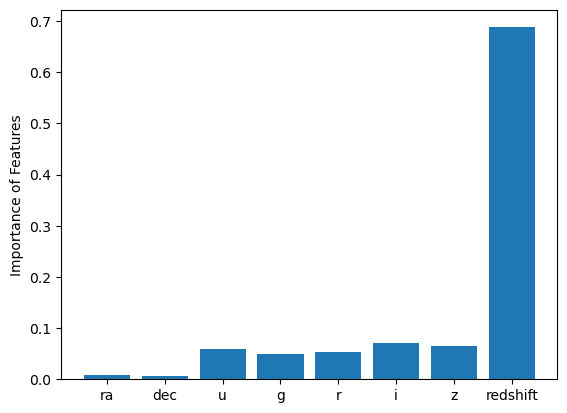

In [151]:
# answer
feat_impt = rf_clf.feature_importances_
plt.bar(x = skyserver_noclass.columns, height = feat_impt)
plt.ylabel('Importance of Features')

In [152]:
print(feat_impt)

[0.00778789 0.00695131 0.05878667 0.04908718 0.05313783 0.07182714
 0.06449352 0.68792847]


**Task: What are the top three features (1 point)?**

The top three most important features are redshift, i, and z

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

see the cell below

 - It was very cool to compare different classifier methods on the same dataset!
 - You can minimize the number of features in datasets that have highly correlated variables
 - It was also interesting to think about the different metrics you can use to evaluate different classifier methods

In [ ]:
# answer below

<!-- answer -->